<div style="text-align: right">INFO 6105 Data Science Eng Methods and Tools, Lecture 14 Day 1</div>
<div style="text-align: right">Dino Konstantopoulos, 6 December 2022, with material from Willie Wheeler</div>

# Boostrapping Lab
I told you that there was a way to build standard deviations using classical techniques rather than Bayesian simulations. Today I want to show you how to do it. It's called **bootstrapping**.

Bootstrapping is any test or metric that uses random sampling with replacement (e.g. mimicking the sampling process), and falls under the broader class of resampling methods. Bootstrapping assigns measures of accuracy (bias, variance, confidence intervals, prediction error, etc.) to sample estimates. This technique allows estimation of the sampling distribution of almost any statistic using random sampling methods.

Bootstrapping estimates the properties of an estimand (such as its variance) by measuring those properties when sampling from an approximating distribution. One standard choice for an approximating distribution is the empirical distribution function of the observed data. In the case where a set of observations can be assumed to be from an independent and identically distributed population, this can be implemented by constructing a number of resamples with replacement, of the observed data set (and of equal size to the observed data set).

It may also be used for constructing hypothesis tests. It is often used as an alternative to statistical inference based on the assumption of a parametric model when that assumption is in doubt, or where parametric inference is impossible or requires complicated formulas for the calculation of standard errors.

Let's warm up with using an MC simulation to estimate a probability

# 1. Monte Carlo sim to estimate a probability

### Hypothetical Problem
The logarithms of weights (in pounds) of men in the United States are approximately normally distributed with mean 5.13 and standard deviation 0.17; women’s log weights are approximately normally distributed with mean 4.96 and standard deviation 0.20. Suppose 10 adults selected at random step on an elevator with a capacity of 1750 pounds. What is the probability that their total weight exceeds this limit?

We need to estimate the probability that the 10 randomly selected adults together weigh more than 1,750 pounds. An individual man’s weight follows a lognormal distribution, and an individual woman’s weight follows a different lognormal distribution. If the problem were to estimate the probability that a single randomly selected adult’s weight exceeds some value — maybe 180 pounds — this would be easy enough to do analytically. But the part where we choose 10 adults at random makes it harder.

Write a simple computer simulation that we can run a bunch of times. Each run will generate a single total weight (the random variable under study) by generating a random sets of adults, each of whom has a randomly generated weight according to the corresponding lognormal distribution. The set of runs gives us a distribution. Then we’ll just look at the proportion of runs where the total weight exceeds 1,750 pounds, and that’s our estimate.

There’s one unstated parameter we need to make explicit, which is the proportion of men versus women in the United States. According to the book, the proportions are men = 0.48 and women = 0.52.

In [1]:
pr_male = 0.48
man_log_weight_mean = 5.13
man_log_weight_std = 0.17
woman_log_weight_mean = 4.96
woman_log_weight_std = 0.20
num_adults = 10
weight_limit = 1750

Write a Monte Carlo simulation that yields the distribution of the total weight of 10 adults using the following distributions:
```
np.random.binomial()
```

and
```
np.random.normal
```

In [49]:
import numpy as np
num_sims = 1000
total_weight = []

for s in range(num_sims):
    male = np.random.binomial(1, pr_male)
    if male == 1:
        logweight = np.random.normal(man_log_weight_mean, man_log_weight_std, num_adults)
    else:
        logweight = np.random.normal(woman_log_weight_mean, woman_log_weight_std, num_adults)
    weight = np.exp(logweight)
    total_weight.append(sum(weight))

The solution is here below. Only click below *after* you finished writing your code!

<div hidden>
    import numpy as np
num_sims = 1000
total_weight = []
for s in range(num_sims):
    male = np.random.binomial(1, pr_male)
    if male == 1:
        logweight = np.random.normal(man_log_weight_mean, man_log_weight_std, num_adults)
    else:
        logweight = np.random.normal(woman_log_weight_mean, woman_log_weight_std, num_adults)
    weight = np.exp(logweight)
    total_weight.append(sum(weight))
</div>

Distribution of total weight of 10 adults:

(array([ 17., 100., 193., 164., 160., 162., 132.,  61.,   9.,   2.]),
 array([1208.05374774, 1295.62051312, 1383.18727851, 1470.75404389,
        1558.32080927, 1645.88757466, 1733.45434004, 1821.02110542,
        1908.58787081, 1996.15463619, 2083.72140157]),
 <a list of 10 Patch objects>)

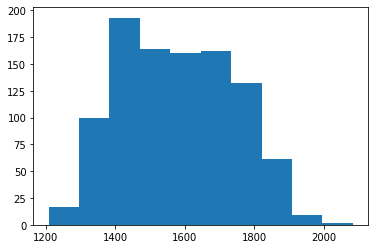

In [54]:
import matplotlib.pyplot as plt
%matplotlib inline
plt.hist(total_weight)

From the above we can see that a majority of the runs result in totals less than 1,750 pounds. Looks like maybe 15% are over the limit. Calculate a precise estimate here below. Please write your own code, and only *after* you have a result, then click on the cell further below to double-check your result.

In [108]:
len(list(filter(lambda w: w > 1750, total_weight))) / num_sims

0.178

<div hidden>
    len(list(filter(lambda w: w > 1750, total_weight))) / num_sims
</div>

The answer for my 1,000 runs is 18%, so that’s my estimate.

# 2. What-if analyses
Say we own a web service and we want to improve the processing time for one of the web service endpoints. 

Behind the scenes, request processing happens in stages, each with its own duration, and these sum to produce an overall duration. 

We’d like to conduct experiments that explore the impact of component distribution changes on the overall distribution. Such experiments would allow us to answer questions like:

- How can we reduce the 95th precentile of the total duration by 10%?
- How can we reduce standard deviation of the total duration by 20%?
- We want to make a change to one of the stages that will increase both mean and standard deviation of the duration by a certain amount. What will be the impact on the 50th percentile and the 90th precentile of the total duration?

We can use probability simulations to conduct analyses of this sort. The basic idea is to create a simulation that generates random values at each stage according to underlying component distributions, and then sums them to get a total. Run the simulation a large number of times to generate histograms from which we can extract corresponding probability distributions.

First, we have the simulation itself. For the sake of this simulation, assume three lognormal component distributions. 

The lognormal distribution takes a mean and standard deviation of the random variable’s natural log. So here we take a list `m` of three means, a list `sd` of three standard deviations, and a count `n` of how many simulation runs we want to conduct:

In [73]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [74]:
rng = np.random.default_rng(42)
n = 1000
xrange = [0, 100]

In [75]:
def plot_stages(s0, s1, s2, total):
    fig, ax = plt.subplots(1, 4, figsize=(12, 2), sharex=True, tight_layout=True)

    ax[0].hist(s0, bins=20, range=xrange)
    ax[0].set_title("S0 duration")

    ax[1].hist(s1, bins=20, range=xrange)
    ax[1].set_title("S1 duration")

    ax[2].hist(s2, bins=20, range=xrange)
    ax[2].set_title("S2 duration")

    ax[3].hist(total, bins=20, range=xrange)
    ax[3].set_title("Total duration")

Copy paste the simulation in the cell below:
```
def run_sim(m, sd, n):
    s0 = rng.lognormal(m[0], sd[0], n)
    s1 = rng.lognormal(m[1], sd[1], n)
    s2 = rng.lognormal(m[2], sd[2], n)
    total = s0 + s1 + s2
    plot_stages(s0, s1, s2, total)
    print(f"Total p50, p95, p99={np.quantile(total, [0.5, 0.95, 0.99])}")
```

In [76]:
def run_sim(m, sd, n):
    s0 = rng.lognormal(m[0], sd[0], n)
    s1 = rng.lognormal(m[1], sd[1], n)
    s2 = rng.lognormal(m[2], sd[2], n)
    total = s0 + s1 + s2
    plot_stages(s0, s1, s2, total)
    print(f"Total p50, p95, p99={np.quantile(total, [0.5, 0.95, 0.99])}")

##  Baseline
Suppose we have the following baselines for `s0`, ``s1`, and `s2`:
```
base_mean = [2.5, 3.1, 2.1]
base_sd = [0.3, 0.4, 0.5]
```

Obtain the histograms of the `S` components and the total duration:

Total p50, p95, p99=[44.23123653 65.76615658 79.82980438]


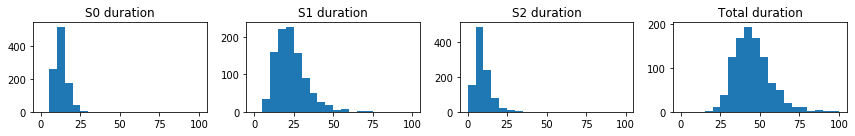

In [77]:
run_sim(base_mean, base_sd, n)

<div hidden>
run_sim(base_mean, base_sd, n)

## Improved
After that, we can do any number of what-if analyses. Say for instance we want to drive the total 95th percentile down from 65.77 ms to something under 50 ms. 

Would it be sufficient to improve the S1 mean log duration from 3.1 to 2.5?

Try it out:

Total p50, p95, p99=[34.00306246 50.57691425 60.7650326 ]


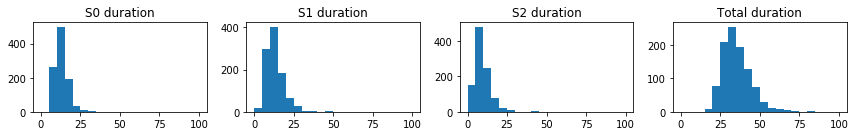

In [78]:
imp_mean = [2.5, 2.5, 2.1]
imp_sd = base_sd
run_sim(imp_mean, imp_sd, n)

<div hidden>
imp_mean = [2.5, 2.5, 2.1]
imp_sd = base_sd
run_sim(imp_mean, imp_sd, n)

If you look carefully at the charts, you will be able to see that the S1 distribution is both lower and tighter (remember that we’re dealing with logarithms here) in the improved system as compared to the baseline system, and so the total distribution is similarly improved. The new 95th percentile is 50.58 ms, which doesn’t quite reach our goal, but is very close.

>**Note**: We consider percentile statistics, but obviously we can compare means, standard deviations, ranges or whatever else we find useful.

# 3.Sampling from an empirical distribution using the bootstrap algorithm
The following dataset contains duration data for 20,000 requests to a given web service endpoint. For each request, the endpoint queries a database, processes the result set, and returns a response. Accordingly, each request has a query duration, a processing duration, and total duration that sums the two.

One important point is that each request is either *small* or *large*, though the dataset does not include these labels. *Small* and *large* refer to the size of the query result set, not to the number of requests. There are 15,000 small requests and 5,000 large requests.

Here’s functionality for plotting histograms for the query durations:

In [79]:
def left_trunc(data):
    zeros = np.zeros(data.shape[0])
    return np.maximum(zeros, data)

In [80]:
def dump_quantiles(data_ctrl, data_exp):
    q = [0.25, 0.5, 0.75, 0.9, 0.95, 0.99]
    q_ctrl = np.quantile(data_ctrl, q)
    q_exp = np.quantile(data_exp, q)
    print("Baseline        Experiment")
    print(f"p25={q_ctrl[0]:6.2f}      p25={q_exp[0]:6.2f}")
    print(f"p50={q_ctrl[1]:6.2f}      p50={q_exp[1]:6.2f}")
    print(f"p75={q_ctrl[2]:6.2f}      p75={q_exp[2]:6.2f}")
    print(f"p90={q_ctrl[3]:6.2f}      p90={q_exp[3]:6.2f}")
    print(f"p95={q_ctrl[4]:6.2f}      p95={q_exp[4]:6.2f}")
    print(f"p99={q_ctrl[5]:6.2f}      p99={q_exp[5]:6.2f}")

In [81]:
def plot_data(data, title, plot_range):
    plt.hist(data, bins=100, range=plot_range)
    plt.title(title)

In [82]:
def plot_sim_vs_observed(data_obs, title_obs, data_sim, title_sim, plot_range):
    fig, ax = plt.subplots(nrows=2, ncols=1, tight_layout=True, sharex=True, sharey=False, figsize=(8, 5))

    ax[0].hist(data_obs, bins=100, range=plot_range)
    ax[0].set_title(title_obs)
    ax[0].set_ylabel("Count")

    ax[1].hist(data_sim, bins=100, range=plot_range)
    ax[1].set_title(title_sim)
    ax[1].set_xlabel("Duration (ms)")
    ax[1].set_ylabel("Count")

### Generate observations
Our hypothetical process is a web service endpoint that queries a database for a list of records, does some processing on each, and then returns the result of that processing to the user. Both query time and processing time are roughly linear in the size of the record list.

There is a **mix*** of two request classes: a *small* class and a *large* class. *Small* and *large* refer to the number of records returned rather than the number of requests. Indeed we will have more small requests than large requests.

Even though we're manufacturing this data, we'll treat it as actual observations. That is, we will treat the manufactured data as the simulation target.

In [83]:
# Counts for small vs large requests
n_total = 20000
n_small = 15000
n_large = n_total - n_small

query_err_small = rng.normal(0.0, 3.0, n_small)
query_err_large = rng.normal(0.0, 3.0, n_large)
query_dur_small = left_trunc(65.3 + rng.lognormal(1.6, 1.0, n_small) + query_err_small)
query_dur_large = left_trunc(85.2 + rng.lognormal(1.6, 1.0, n_large) + query_err_large)
query_dur = np.hstack((query_dur_small, query_dur_large))

cpu_err_small = rng.normal(0.0, 3.0, n_small)
cpu_err_large = rng.normal(0.0, 3.0, n_large)
cpu_dur_small = left_trunc(10.0 + 0.3 * query_dur_small + cpu_err_small)
cpu_dur_large = left_trunc(38.0 + 0.3 * query_dur_large + cpu_err_large)
cpu_dur = np.hstack((cpu_dur_small, cpu_dur_large))

total_dur = query_dur + cpu_dur

Let's plot the query and CPU durations, as well as the total duration:
```
plot_data(query_dur, "Query duration (ms)", [0, 300])
```

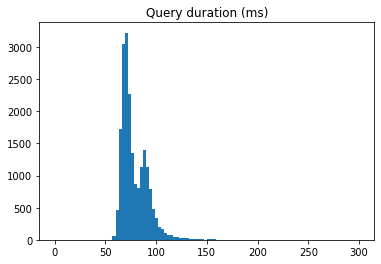

In [84]:
plot_data(query_dur, "Query duration (ms)", [0, 300])

```
plot_data(cpu_dur, "CPU duration (ms)", [0, 300])
```

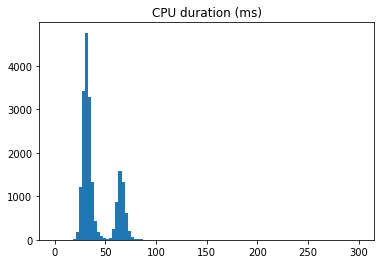

In [85]:
plot_data(cpu_dur, "CPU duration (ms)", [0, 300])

```
plot_data(total_dur, "Total duration (ms)", [0, 300])
```

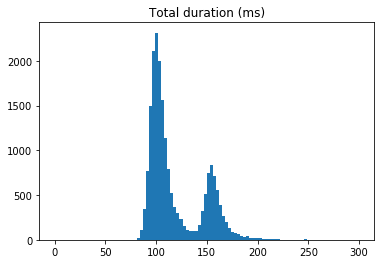

In [86]:
plot_data(total_dur, "Total duration (ms)", [0, 300])

In all three histograms, it’s easy to see that the data is a mix of ***two*** (normal) request classes.

There’s a second important point about our dataset. The query duration and CPU duration are **correlated**. Basically, requests involving larger result sets take longer for both querying and processing. Here’s a scatterplot that shows not only the correlation but the two request classes:
```
import random

i = random.sample(range(0, n_total), 1000)
plt.figure(figsize=(8, 8))
plt.title("CPU duration vs query duration")
plt.scatter(x=query_dur[i], y=cpu_dur[i], s=0.1)
plt.xlim(0, 200)
plt.ylim(0, 150)
plt.xlabel("Query duration (ms)")
plt.ylabel("CPU duration (ms)")
```

Text(0, 0.5, 'CPU duration (ms)')

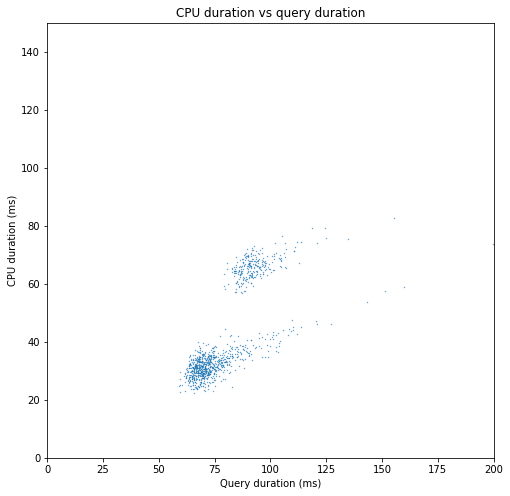

In [87]:
import random

i = random.sample(range(0, n_total), 1000)
plt.figure(figsize=(8, 8))
plt.title("CPU duration vs query duration")
plt.scatter(x=query_dur[i], y=cpu_dur[i], s=0.1)
plt.xlim(0, 200)
plt.ylim(0, 150)
plt.xlabel("Query duration (ms)")
plt.ylabel("CPU duration (ms)")

Our goal is to create a simulation that allows us to manipulate the query and processing duration distributions and see the impact on the total duration distribution. To do this, we need to have a way to sample from the two input distributions, and then we need a way to combine them into the output distribution.

## Bootstrapping is sampling from an empirical distribution
We can use something called **bootstrap sampling** to get new samples, even in the face of correlated inputs. 

Bootstrapping is normally for estimating sampling distribution statistics, but here we’re using it to generate a dataset to drive our simulation. The idea is to select `n` rows from the dataset at random and **with replacement**. Because we select the entire row (all variables, not just one of them), we preserve any relationships that might exist *between* the variables.

```
n_sample = 10000
i_sample = random.choices(range(0, n_total), k=n_sample)
query_sample = query_dur[i_sample]
```

In [109]:
n_sample = 10000
i_sample = random.choices(range(0, n_total), k=n_sample)
query_sample = query_dur[i_sample]

```
plot_sim_vs_observed(
    query_dur, "Query duration, observed",
    query_sample, "Query duration, sampled",
    [0, 300])
```

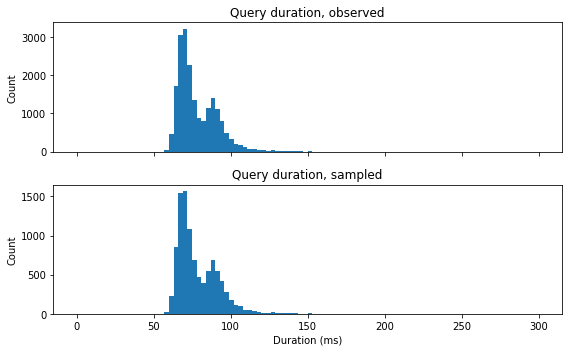

In [110]:
plot_sim_vs_observed(
    query_dur, "Query duration, observed",
    query_sample, "Query duration, sampled",
    [0, 300])

```
dump_quantiles(query_dur, query_sample)
```

In [111]:
dump_quantiles(query_dur, query_sample)

Baseline        Experiment
p25= 68.72      p25= 68.72
p50= 73.79      p50= 73.97
p75= 87.13      p75= 87.50
p90= 94.81      p90= 95.44
p95=101.00      p95=101.59
p99=123.68      p99=123.23


We drew 10,000 records (with replacement) to keep the shape and smoothness consistent between the original and the sample. We can see that the match is very good.

Note that this technique won’t always work well. For example, it wouldn’t work well for sparse, high-dimensional data. 

Now we know how to generate new samples from a given empirical distribution. Let’s apply this knowledge to what-if simulations.

## What-if analysis
For our what-if analysis, we’d like to understand the impact of making improvements to query durations, CPU durations, or both on the overall duration. That way we can identify the options available to bring the overall duration down to meet a given service level objective (SLO).

To do this, we have to be able to sample from the component distributions, which we now know how to do. Then we sum the component durations to get the overall duration.

First, let’s define a function to allow us to run the simulation:
```
def run_sim(query_data, cpu_data, n, k_query=1.0, k_cpu=1.0):
    i_sample = random.choices(range(0, n_total), k=n)
    return k_query * query_data[i_sample] + k_cpu * cpu_data[i_sample]

n_sim = 10000
```

In [112]:
def run_sim(query_data, cpu_data, n, k_query=1.0, k_cpu=1.0):
    i_sample = random.choices(range(0, n_total), k=n)
    return k_query * query_data[i_sample] + k_cpu * cpu_data[i_sample]

n_sim = 10000

In the function above,

- query_data and cpu_data are arrays containing query and CPU data,
- n is the number of simulation runs,
- k_query and k_cpu are multipliers on the query and CPU components.

Now we have a simulation that we hope will serve as the basis for doing some what-if experiments. First let’s verify its correctness by using it to generate something like the baseline duration data.

### Verify the simulation
First we want to make sure that the function generates something reasonable. So we’ll run it with the default k_query and k_cpu and see how it looks compared to the observed total duration.
```
sim_sample_baseline = run_sim(query_dur, cpu_dur, n_sim)
```

In [113]:
sim_sample_baseline = run_sim(query_dur, cpu_dur, n_sim)

```
plot_sim_vs_observed(
    total_dur, "Total duration, observed",
    sim_sample_baseline, "Total duration, simulated",
    [0, 300])
```

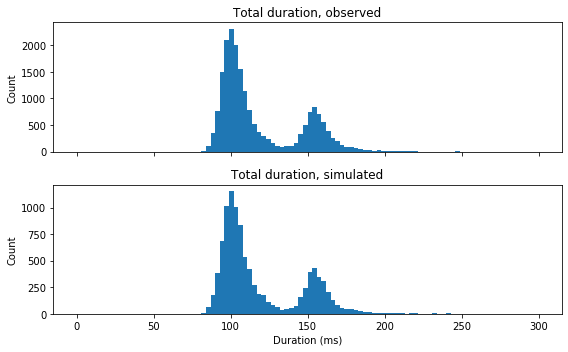

In [114]:
plot_sim_vs_observed(
    total_dur, "Total duration, observed",
    sim_sample_baseline, "Total duration, simulated",
    [0, 300])

```
dump_quantiles(total_dur, sim_sample_baseline)
```

In [115]:
dump_quantiles(total_dur, sim_sample_baseline)

Baseline        Experiment
p25= 99.20      p25= 99.45
p50=106.47      p50=106.60
p75=146.18      p75=146.41
p90=159.28      p90=159.29
p95=166.28      p95=165.68
p99=189.75      p99=189.17


The generated sample is nearly identical to the original, both qualitatively and quantitatively. This gives us confidence that we can use the components to generate the overall duration. So now let’s do some what-if experiments.

## Experiment #1: faster queries
What if we make queries 20% faster?
```
sim_sample_whatif_query = run_sim(query_dur, cpu_dur, n_sim, k_query=0.8)
```

In [118]:
sim_sample_whatif_query = run_sim(query_dur, cpu_dur, n_sim, k_query=0.8)

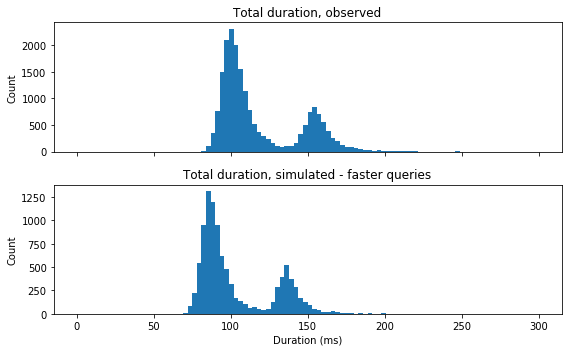

In [119]:
plot_sim_vs_observed(
    total_dur, "Total duration, observed",
    sim_sample_whatif_query, "Total duration, simulated - faster queries",
    [0, 300])

In [120]:
dump_quantiles(total_dur, sim_sample_whatif_query)


Baseline        Experiment
p25= 99.20      p25= 85.60
p50=106.47      p50= 92.00
p75=146.18      p75=128.97
p90=159.28      p90=140.39
p95=166.28      p95=146.18
p99=189.75      p99=166.99


## Faster CPU
What if we make CPU 20% faster?
```
sim_sample_whatif_cpu = run_sim(query_dur, cpu_dur, n_sim, k_cpu=0.8)
```

In [121]:
sim_sample_whatif_cpu = run_sim(query_dur, cpu_dur, n_sim, k_cpu=0.8)

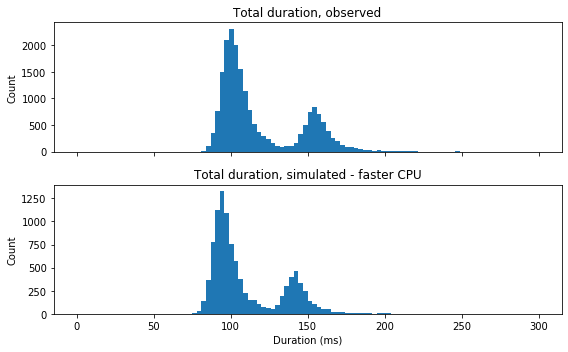

In [122]:
plot_sim_vs_observed(
    total_dur, "Total duration, observed",
    sim_sample_whatif_cpu, "Total duration, simulated - faster CPU",
    [0, 300])

In [123]:
dump_quantiles(total_dur, sim_sample_whatif_cpu)

Baseline        Experiment
p25= 99.20      p25= 93.17
p50=106.47      p50= 99.56
p75=146.18      p75=132.65
p90=159.28      p90=145.63
p95=166.28      p95=151.88
p99=189.75      p99=174.69


## Faster queries *and* CPU
What if we make queries *and* CPU 20% faster?
```
sim_sample_whatif_both = run_sim(query_dur, cpu_dur, n_sim, k_query=0.8, k_cpu=0.8)
```

In [124]:
sim_sample_whatif_both = run_sim(query_dur, cpu_dur, n_sim, k_query=0.8, k_cpu=0.8)

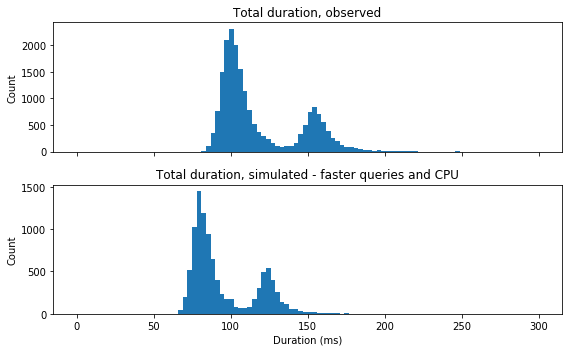

In [125]:
plot_sim_vs_observed(
    total_dur, "Total duration, observed",
    sim_sample_whatif_both, "Total duration, simulated - faster queries and CPU",
    [0, 300])

In [126]:
dump_quantiles(total_dur, sim_sample_whatif_both)

Baseline        Experiment
p25= 99.20      p25= 79.50
p50=106.47      p50= 85.60
p75=146.18      p75=117.54
p90=159.28      p90=127.54
p95=166.28      p95=132.99
p99=189.75      p99=151.34


## Experiment #4: *slower* queries
What if we make queries 30% *slower*?

This one may seem a little funny, but consider the following use case: We need to make a change to the queries that will make them take longer, and we need to know whether the impact on the overall duration still meets our service level objective.
```
sim_sample_whatif_query2 = run_sim(query_dur, cpu_dur, n_sim, k_query=1.3)
```

In [127]:
sim_sample_whatif_query2 = run_sim(query_dur, cpu_dur, n_sim, k_query=1.3)

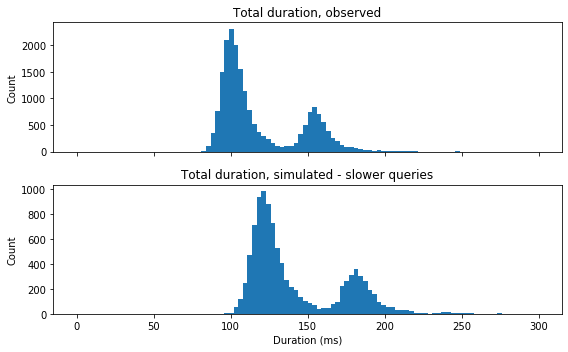

In [128]:
plot_sim_vs_observed(
    total_dur, "Total duration, observed",
    sim_sample_whatif_query2, "Total duration, simulated - slower queries",
    [0, 300])

In [107]:
dump_quantiles(total_dur, sim_sample_whatif_query2)

Baseline        Experiment
p25= 99.20      p25=119.83
p50=106.47      p50=128.65
p75=146.18      p75=172.67
p90=159.28      p90=187.65
p95=166.28      p95=196.05
p99=189.75      p99=225.21


## Conclusion
The approach for building probability simulations for response time data was to decompose an overall (mixed) response time into component response times, randomly generate the component response times according to an appropriate probability distribution, and then add them up to get the overall response time and corresponding distribution of response times. This allows us to run “what-if” scenarios, such as “what would happen to the overall response time if we were to speed up the database queries by 20%?”
 
Sampling from empirical distributions (bootstrapping) gives us the ability to build simulations that incorporate complex distributions of the sort that often occur in the real world. We can then use these simulations to run experiments that explore the distributional relationship between system inputs and outputs.

Something interesting that can happen is that the component response times can be correlated with one another. This isn’t a big surprise: if we have a web request that involves querying a database, larger result sets will often drive longer query times and result processing times.

# 4. Bootstrapping a statistical Moment
Using Bootstrap sampling, we can estimate the uncertainty of a mean by generating samples from our data and then characterize the distribution of the mean over these samples.

In [129]:
total_dur

array([103.4275629 , 100.8159052 , 104.58513538, ..., 150.09478214,
       154.37975454, 151.63225435])

In [130]:
import pandas as pd
df = pd.DataFrame(total_dur)
df

,0
0,103.427563
1,100.815905
2,104.585135
3,103.206004
4,88.153782
...,...
19995,165.680773
19996,160.943656
19997,150.094782
19998,154.379755


In [132]:
df[0].describe()

count    20000.000000
mean       119.006586
std         28.398948
min         81.738047
25%         99.197979
50%        106.472422
75%        146.176733
max       1115.154830
Name: 0, dtype: float64

We generate 500 samples (with replacement) from our dataset, take the mean of these 500 samples, and then characterize this operation by repeating this process 1,000 times, giving us a **distribution** of the mean over these samples.

In [143]:
bootstrap=pd.DataFrame({'mean_duration':[df.sample(500, replace=True)[0].mean() for i in range(0,1000)]})
bootstrap

,mean_duration
0,118.098031
1,119.262395
2,117.816933
3,117.892145
4,119.552691
...,...
995,119.125199
996,118.008174
997,120.853293
998,119.617203


Plotting the histogram of the bootstrapped samples, we can clearly see that it approximates a normal distribution, even though the original distribution is a mix of ***two*** different normal components! This is in line with the **Central Limit Theorem** that posits *exactly that*!

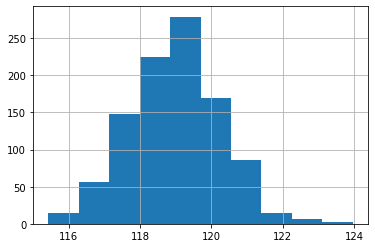

In [144]:
bootstrap['mean_duration'].hist()

Now, we can extract the quantiles in order to get a **95% confidence interval**:

In [145]:
(bootstrap['mean_duration'].quantile(0.025), bootstrap['mean_duration'].quantile(0.975))

(116.52529450558552, 121.37791960756049)

Bootstrap-approximated 95% confidence interval of the mean duration is between 116.5 and 121.4. This means that we are 95% confident that the population mean, lies in that range.

Indeed it does:

In [147]:
df[0].mean()

119.00658636666539

While Bootstrapping can be useful, you should be careful of the sample you will use. It needs to be representative of the orignial dataset in order to capture the population characteristics adequately. In our case, I only sampled 500 points, but I did repeat this process 1,000 times. I was successful in capturing a good interval for the mean, without any model construction.

But I much prefer to build a model with Bayesian estimation!

# Homework
Use **Bayesian estimation** to conduct the same analysis using a **Gaussian Mixture Model**.

Note: *No more* homework for next week. Work on your final project instead!